<a href="https://colab.research.google.com/github/tommasorigon/CompStat/blob/main/notebook/un_B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit B.2 - MALA algorithm & Hamiltonian Monte Carlo

In this unit we discuss several advanced MCMC strategies that have been presented in the [**slides of unit B.2**](../slides/un_B2.pdf) and [**slides of unit C.2**](../slides/un_C2.pdf), including **MALA**, **Hamiltonian Monte Carlo** and the Gibbs sampling based on the **Pólya-gamma data augmentation**. 

We will implement these proposals using the "famous" **Pima indian dataset**, as in the previous [**Notebook B.1**](https://colab.research.google.com/github/tommasorigon/CompStat/blob/main/notebook/un_B1.ipynb). Let me stress again that the purpose of this unit is mainly presenting the implementation of the various MCMC algorithms and not making "inference" about their general performance. Refer to the nice paper by [Chopin & Ridgway (2017)](https://projecteuclid.org/journals/statistical-science/volume-32/issue-1/Leave-Pima-Indians-Alone--Binary-Regression-as-a-Benchmark/10.1214/16-STS581.full) for a more comprehensive discussion on this aspect. 


## Pima indian dataset

We will make use of the Pima indian dataset again, as in the previous [**Notebook B.1**](https://colab.research.google.com/github/tommasorigon/CompStat/blob/main/notebook/un_B1.ipynb). Importantly, note that in this document we will **not standardize the predictors** to make the computational problem more challenging. 


In [4]:
Pima <- rbind(MASS::Pima.tr, MASS::Pima.te)
y <- as.numeric(Pima$type == "Yes") # Binary outcome
X <- cbind(1, model.matrix(type ~ . - 1, data = Pima)) # Design matrix

In [8]:
install.packages("RcppArmadillo")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [16]:
download.file("https://tommasorigon.github.io/CompStat/cpp/RMH.cpp", "RMH.cpp")
Rcpp::sourceCpp("RMH.cpp")

As done in [**Notebook B.1**](https://colab.research.google.com/github/tommasorigon/CompStat/blob/main/notebook/un_B1.ipynb), we will employ a relatively vague prior centered at $0$, namely $\beta \sim N(0, 100 I_p)$. Then, we implement the log-likelihood, the log-posterior and the **gradient** of the likelihood.



In [14]:
# Log-likelihood of a logistic regression model
loglik <- function(beta, y, X) {
  eta <- c(X %*% beta)
  sum(y * eta - log(1 + exp(eta)))
}

# Log-posterior
logpost <- function(beta, y, X) {
  loglik(beta, y, X) + sum(dnorm(beta, 0, 10, log = T))
}

# Gradient of the logposterior
lgradient <- function(beta, y, X) {
  probs <- plogis(c(X %*% beta))
  loglik_gr <- c(crossprod(X, y - probs))
  prior_gr <- -beta / 100
  loglik_gr + prior_gr
}

# Summary table for the 6 considered methods
summary_tab <- matrix(0, nrow = 6, ncol = 4)
colnames(summary_tab) <- c("Seconds", "Average ESS", "Average ESS per sec", "Average acceptance rate")
rownames(summary_tab) <- c("MH Laplace + Rcpp", "MALA", "MALA tuned", "HMC", "STAN", "Pólya-Gamma")

## Metropolis Hastings (Laplace) and Rcpp

We first consider a random walk Metropolis-Hastings algorithm based on *Rcpp* implementation. The source code can be found in [**this file**](https://tommasorigon.github.io/CompStat/cpp/RMH.cpp). We again use a the Fisher information matrix as quick estimate for the covariance matrix. Refer to the [**slides of unit B.1**](../slides/un_B1.pdf) for more about this idea. 


In [15]:
install.packages("coda")
library(coda)
R <- 30000
burn_in <- 5000

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1103    1154    1163    1166    1192    1204 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24.93   25.16   25.79   25.75   26.01   27.19 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2682  0.2682  0.2682  0.2682  0.2682  0.2682 

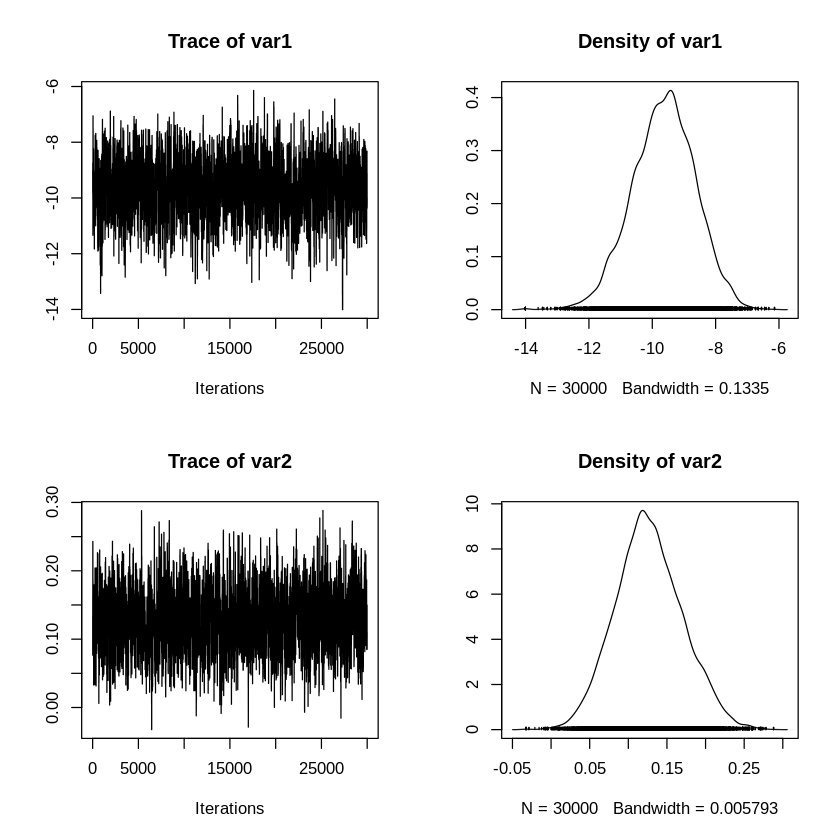

In [17]:
set.seed(123)

# Covariance matrix is selected via laplace approximation
fit_logit <- glm(y ~ X - 1, family = binomial(link = "logit"))
p <- ncol(X)
S <- 2.38^2 * vcov(fit_logit) / p

# Running the MCMC
start.time <- Sys.time()
# MCMC
fit_MCMC <- as.mcmc(RMH_arma(R, burn_in, y, X, S)) # Convert the matrix into a "coda" object
end.time <- Sys.time()

time_in_sec <- as.numeric(difftime(end.time, start.time, units = "secs"))

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[1, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])


## MALA algoritm

The MALA algorithm is described in the [**slides of unit B.2**](../slides/un_B2.pdf). Here we propose a general implementation which allows to specify a pre-conditioning matrix `S` and a scaling parameter `epsilon`. 


In [18]:
# R represent the number of samples
# burn_in is the number of discarded samples
# epsilon, S are tuning parameter
MALA <- function(R, burn_in, y, X, epsilon, S) {
  p <- ncol(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values
  beta <- rep(0, p) # Initial values
  A <- chol(S) # Cholesky of S
  S1 <- solve(S) # Inverse of S

  lgrad <- c(S %*% lgradient(beta, y, X)) # Compute the gradient
  logp <- logpost(beta, y, X)

  sigma2 <- epsilon^2 / p^(1 / 3)
  sigma <- sqrt(sigma2)

  # Starting the Gibbs sampling
  for (r in 1:(burn_in + R)) {
    beta_new <- beta + sigma2 / 2 * lgrad + sigma * c(crossprod(A, rnorm(p)))

    logpnew <- logpost(beta_new, y, X)
    lgrad_new <- c(S %*% lgradient(beta_new, y, X))

    diffold <- beta - beta_new - sigma2 / 2 * lgrad_new
    diffnew <- beta_new - beta - sigma2 / 2 * lgrad

    qold <- -diffold %*% S1 %*% diffold / (2 * sigma2)
    qnew <- -diffnew %*% S1 %*% diffnew / (2 * sigma2)

    alpha <- min(1, exp(logpnew - logp + qold - qnew))
    if (runif(1) < alpha) {
      logp <- logpnew
      lgrad <- lgrad_new
      beta <- beta_new # Accept the value
    }
    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

The first run of the MALA algorithm is performed using a diagonal matrix (i.e. no pre-conditioning). As detailed in the [**slides of unit B.2**](../slides/un_B2.pdf), this expected to perform poorly. 



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.900   9.358  27.201  44.321  46.238 166.223 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  180.5   728.7  1208.5  2671.3  3283.2 10343.4 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5638  0.5638  0.5638  0.5638  0.5638  0.5638 

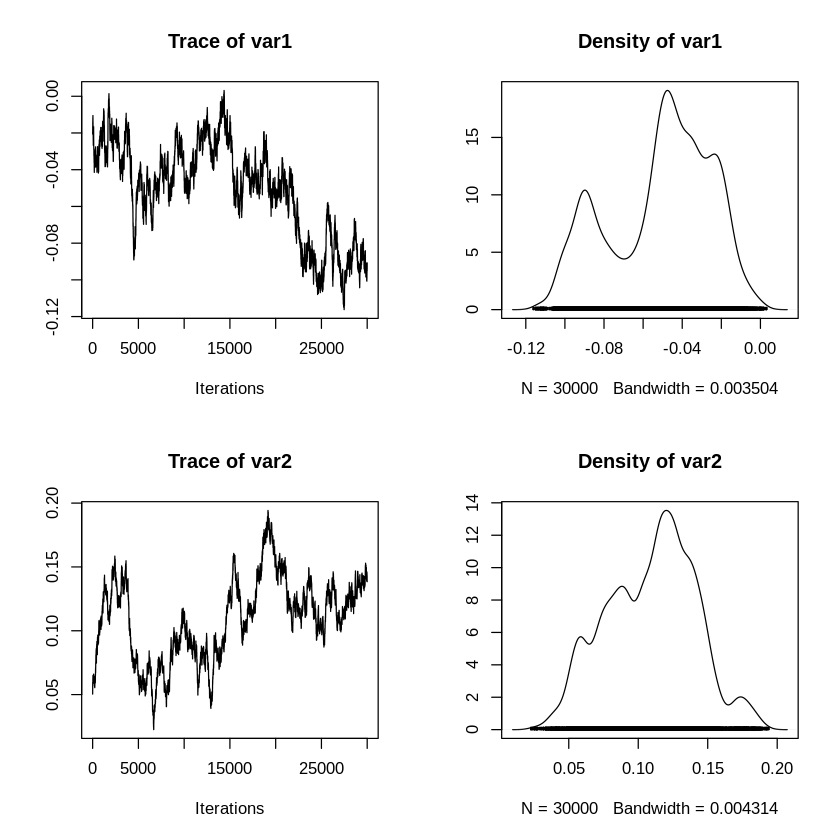

In [19]:
set.seed(123)

epsilon <- 0.0017 # After some trial ad error

# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(MALA(R = R, burn_in = burn_in, y, X, epsilon, S = diag(ncol(X)))) # Convert the matrix into a "coda" object
end.time <- Sys.time()
time_in_sec <- as.numeric(difftime(end.time, start.time, units = "secs"))

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[2, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## MALA algorithm with pre-conditioning

In this second implementation of MALA, we rely instead on the Fisher information matrix, as in the RWM example. This indeed leads to much better results. 


In [20]:
library(coda)
R <- 30000
burn_in <- 5000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8583    8762    9196    9063    9312    9409 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.189   3.222   3.263   3.314   3.424   3.495 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5686  0.5686  0.5686  0.5686  0.5686  0.5686 

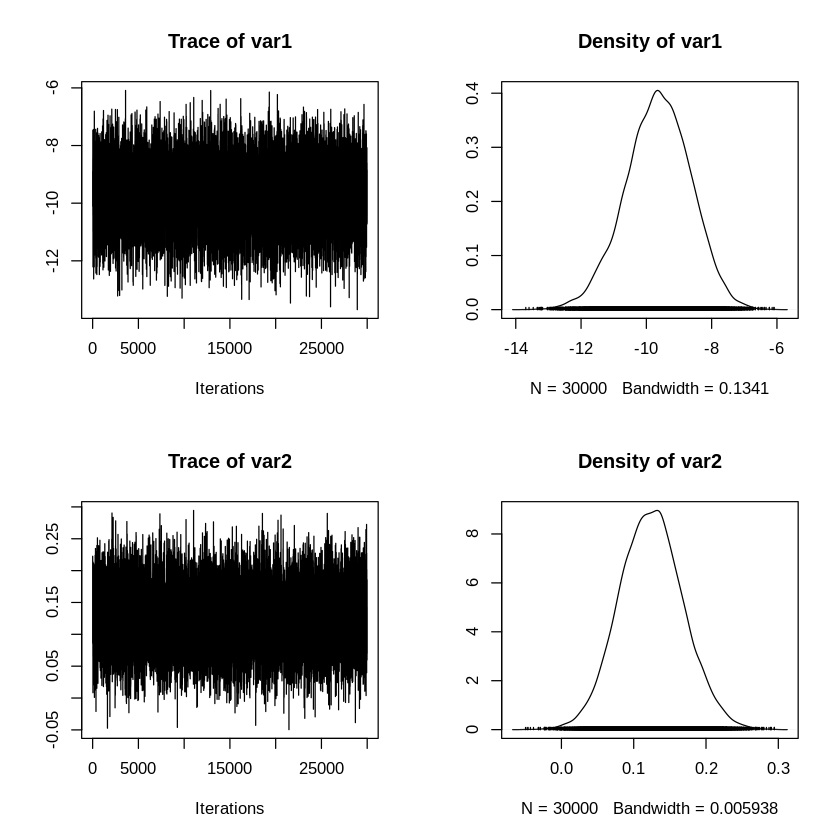

In [21]:
set.seed(123)

epsilon <- 1.68 # After some trial ad error

# Covariance matrix is selected via laplace approximation
fit_logit <- glm(y ~ X - 1, family = binomial(link = "logit"))
S <- vcov(fit_logit)

# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(MALA(R = R, burn_in = burn_in, y, X, epsilon, S)) # Convert the matrix into a "coda" object
end.time <- Sys.time()
time_in_sec <- as.numeric(difftime(end.time, start.time, units = "secs"))

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[3, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## Hamiltonian Monte Carlo

The following `HMC` function is an implementation of Hamiltonian Monte Carlo for a general parametric model. As before, the object `S` represents a pre-conditioning matrix. This code is an adaptation of the one written by [**Neal (2011)**](https://www.mcmchandbook.net/HandbookChapter5.pdf). 


In [22]:
HMC <- function(R, burn_in, y, X, epsilon, S, L = 10) {
  p <- ncol(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values
  beta <- rep(0, p) # Initial values
  logp <- logpost(beta, y, X) # Initial log-posterior
  S1 <- solve(S)
  A1 <- chol(S1)

  # Starting the Gibbs sampling
  for (r in 1:(burn_in + R)) {
    P <- c(crossprod(A1, rnorm(p))) # Auxiliary variables
    logK <- c(P %*% S %*% P / 2) # Kinetic energy at the beginning of the trajectory

    # Make a half step for momentum at the beginning
    beta_new <- beta
    Pnew <- P + epsilon * lgradient(beta_new, y, X) / 2

    # Alternate full steps for position and momentum
    for (l in 1:L) {
      # Make a full step for the position
      beta_new <- beta_new + epsilon * c(S %*% Pnew)
      # Make a full step for the momentum, except at end of trajectory
      if (l != L) Pnew <- Pnew + epsilon * lgradient(beta_new, y, X)
    }
    # Make a half step for momentum at the end.
    Pnew <- Pnew + epsilon * lgradient(beta_new, y, X) / 2

    # Negate momentum at end of trajectory to make the proposal symmetric
    Pnew <- - Pnew

    # Evaluate potential and kinetic energies at the end of trajectory
    logpnew <- logpost(beta_new, y, X)
    logKnew <- Pnew %*% S %*% Pnew / 2 

    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    if (runif(1) < exp(logpnew - logp + logK - logKnew)) {
      logp <- logpnew
      beta <- beta_new # Accept the value
    }

    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

We run the `HMC` using the usual Fisher information matrix as covariance matrix. 



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 215765  222946  226610  225565  228360  233334 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1286  0.1314  0.1324  0.1331  0.1346  0.1390 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9892  0.9892  0.9892  0.9892  0.9892  0.9892 

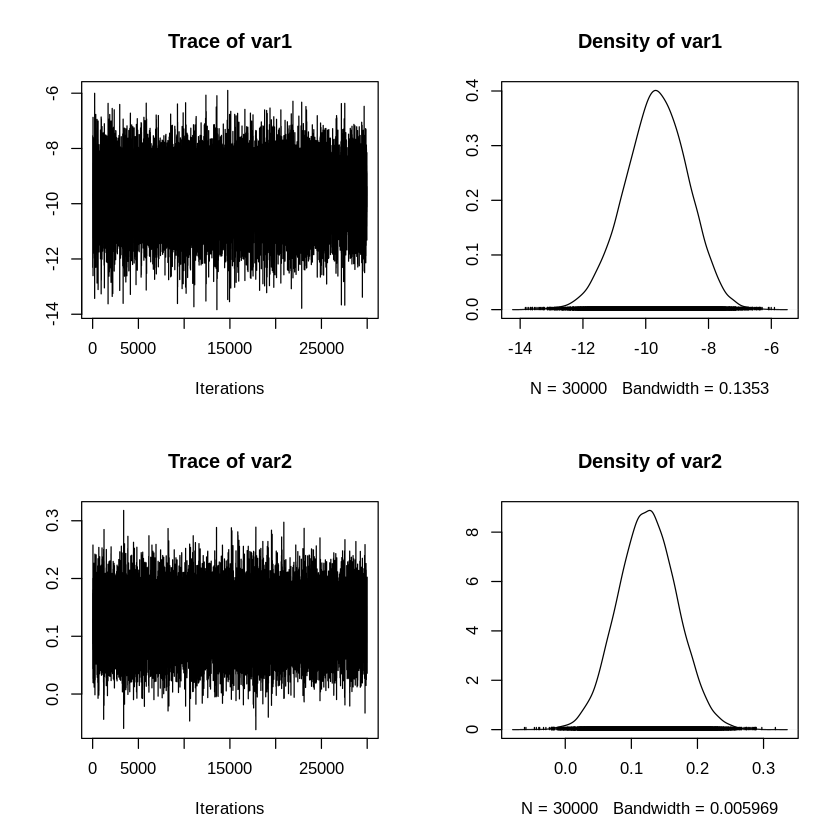

In [23]:
set.seed(123)

epsilon <- 0.25 # After some trial ad error
L <- 10

# Covariance matrix is selected via laplace approximation
fit_logit <- glm(y ~ X - 1, family = binomial(link = "logit"))
S <- vcov(fit_logit)

# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(HMC(R = R, burn_in = burn_in, y, X, epsilon, S, L)) # Convert the matrix into a "coda" object
end.time <- Sys.time()
time_in_sec <- as.numeric(difftime(end.time, start.time, units = "secs"))

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[4, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## Hamiltonian Monte Carlo (Stan)

For the sake of completeness, we also present the results obtained using the **Stan** software, which must be installed alongside the `rstan` R package. The [`logistic.stan`](logistic.stan) is available in this repository. The following chunk of code compile the model in C++. 


In [24]:
install.packages("rstan")

In [25]:
library(rstan)

download.file("https://tommasorigon.github.io/CompStat/cpp/logistic.stan", "logistic.stan")
# I am not counting the compilation time
stan_compiled <- stan_model(file = "logistic.stan") # Stan program

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:coda’:

    traceplot




We then sample the MCMC values and store the results.  




SAMPLING FOR MODEL 'logistic' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.97 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 35000 [  0%]  (Warmup)
Chain 1: Iteration:  3500 / 35000 [ 10%]  (Warmup)
Chain 1: Iteration:  5001 / 35000 [ 14%]  (Sampling)
Chain 1: Iteration:  8500 / 35000 [ 24%]  (Sampling)
Chain 1: Iteration: 12000 / 35000 [ 34%]  (Sampling)
Chain 1: Iteration: 15500 / 35000 [ 44%]  (Sampling)
Chain 1: Iteration: 19000 / 35000 [ 54%]  (Sampling)
Chain 1: Iteration: 22500 / 35000 [ 64%]  (Sampling)
Chain 1: Iteration: 26000 / 35000 [ 74%]  (Sampling)
Chain 1: Iteration: 29500 / 35000 [ 84%]  (Sampling)
Chain 1: Iteration: 33000 / 35000 [ 94%]  (Sampling)
Chain 1: Iteration: 35000 / 35000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 12.1975 seconds (Warm-up)
Chain 1:                82.7983 seconds (Samp

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30000   30000   30000   30099   30000   30795 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9742  1.0000  1.0000  0.9968  1.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

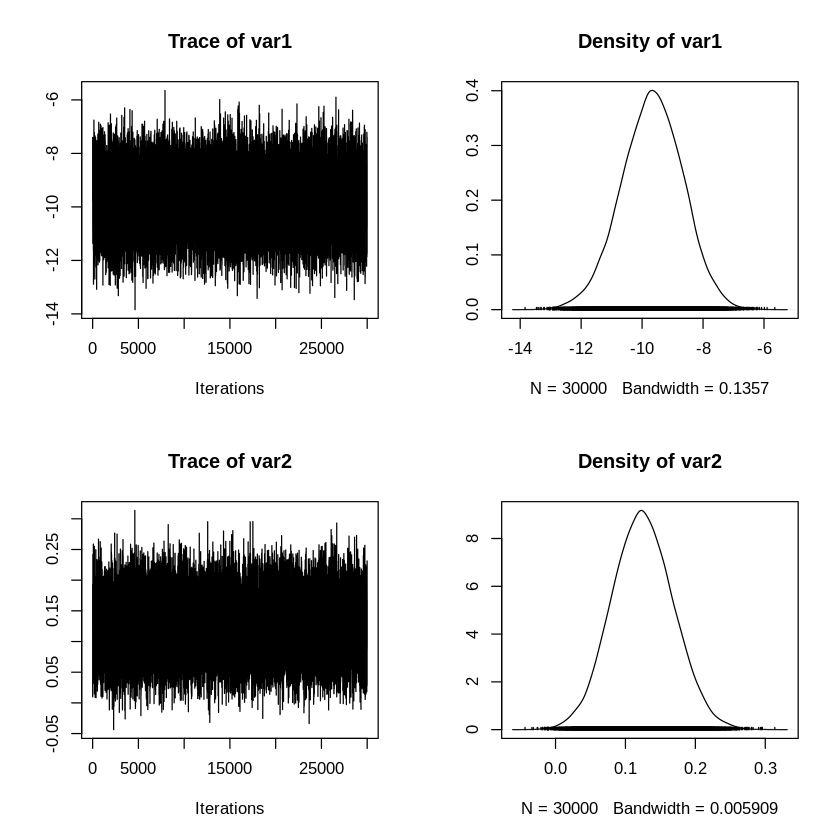

In [26]:
set.seed(1234)
# Running the MCMC
start.time <- Sys.time()
fit_HMC <- sampling(
  stan_compiled, # The stan file has been previously compiled
  data = list(X = X, y = y, n = nrow(X), p = ncol(X)), # named list of data
  chains = 1, # number of Markov chains
  warmup = burn_in, # Burn-in iterations per chain
  iter = R + burn_in # Total number of iterations per chain
)
end.time <- Sys.time()
time_in_sec <- as.numeric(difftime(end.time, start.time, units = "secs"))

fit_HMC <- as.mcmc(extract(fit_HMC)$beta)

# Diagnostic
summary(effectiveSize(fit_HMC)) # Effective sample size
summary(R / effectiveSize(fit_HMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_HMC)) # Acceptance rate

# Summary statistics
summary_tab[5, ] <- c(
  time_in_sec, mean(effectiveSize(fit_HMC)),
  mean(effectiveSize(fit_HMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_HMC))
)

# Traceplot of the intercept
plot(fit_HMC[, 1:2])

## Pólya-gamma data-augmentation

The Pólya-gamma data-augmentation is described in the paper [Polson, N. G., Scott, J. G. and Windle J. (2013)](https://www.tandfonline.com/doi/full/10.1080/01621459.2013.829001). The simulation of the Pólya-gamma random variables is handled by the function `rpg.devroye` within the `BayesLogit` R package.


In [27]:
install.packages("BayesLogit")
library(BayesLogit)

logit_Gibbs <- function(R, burn_in, y, X, B, b) {
  p <- ncol(X)
  n <- nrow(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values

  P <- solve(B) # Prior precision matrix
  Pb <- P %*% b # Term appearing in the Gibbs sampling

  Xy <- crossprod(X, y - 1 / 2)

  # Initialization
  beta <- rep(0, p)

  # Iterative procedure
  for (r in 1:(R + burn_in)) {

    # Sampling the Pólya-gamma latent variables
    eta <- c(X %*% beta)
    omega <- rpg.devroye(num = n, h = 1, z = eta)

    # Sampling beta
    eig <- eigen(crossprod(X * sqrt(omega)) + P, symmetric = TRUE)

    Sigma <- crossprod(t(eig$vectors) / sqrt(eig$values))
    mu <- Sigma %*% (Xy + Pb)

    A1 <- t(eig$vectors) / sqrt(eig$values)
    beta <- mu + c(matrix(rnorm(1 * p), 1, p) %*% A1)

    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [28]:
B <- diag(100, ncol(X)) # Prior covariance matrix
b <- rep(0, ncol(X)) # Prior mean

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10305   13474   14602   14952   17236   18750 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.600   1.741   2.060   2.073   2.227   2.911 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

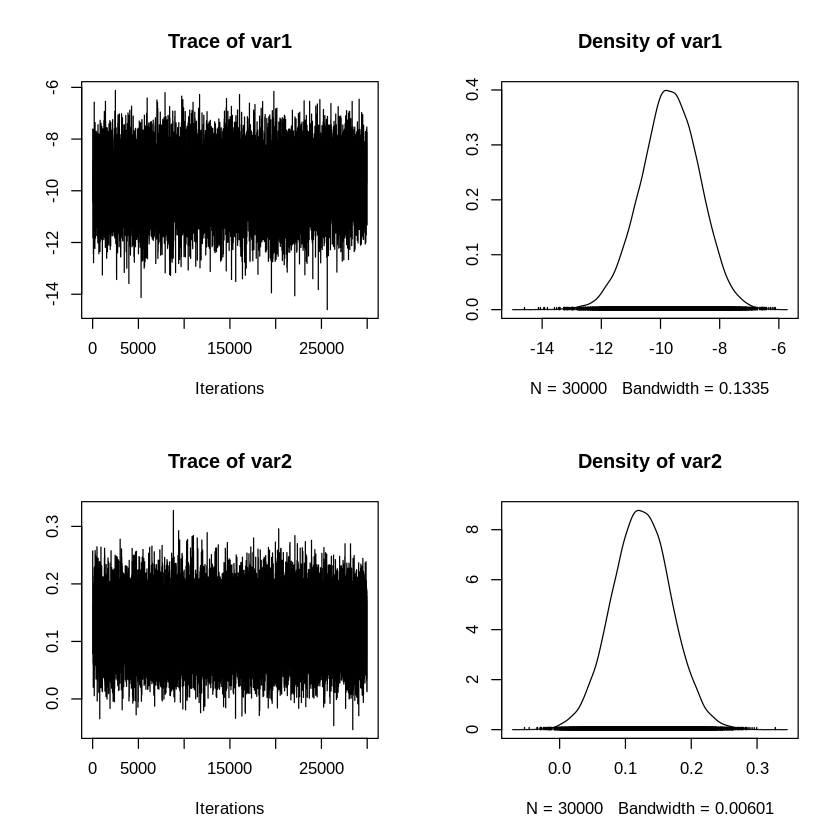

In [29]:
set.seed(123)

# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(logit_Gibbs(R, burn_in, y, X, B, b)) # Convert the matrix into a "coda" object
end.time <- Sys.time()
time_in_sec <- as.numeric(difftime(end.time, start.time, units = "secs"))

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[6, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)


# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## Results

The summary statistics of all the above algorithm are reported in the table below. 


In [30]:
knitr::kable(summary_tab)



|                  |   Seconds|  Average ESS| Average ESS per sec| Average acceptance rate|
|:-----------------|---------:|------------:|-------------------:|-----------------------:|
|MH Laplace + Rcpp |  1.172214|   1165.75640|           994.49068|               0.2682089|
|MALA              |  4.355193|     44.32131|            10.17666|               0.5637855|
|MALA tuned        |  4.250912|   9063.31983|          2132.08823|               0.5686190|
|HMC               | 19.666714| 225565.16881|         11469.38765|               0.9892330|
|STAN              | 96.315470|  30099.36046|           312.50806|               1.0000000|
|Pólya-Gamma       | 17.345875|  14952.42842|           862.01638|               1.0000000|